Using cpu device
force_right:  0.2
loss_left:  tensor(0., grad_fn=<MseLossBackward0>)
loss_right:  tensor(1344.0307, grad_fn=<AddBackward0>)
div_loss:  tensor(8173.6758, grad_fn=<MseLossBackward0>)


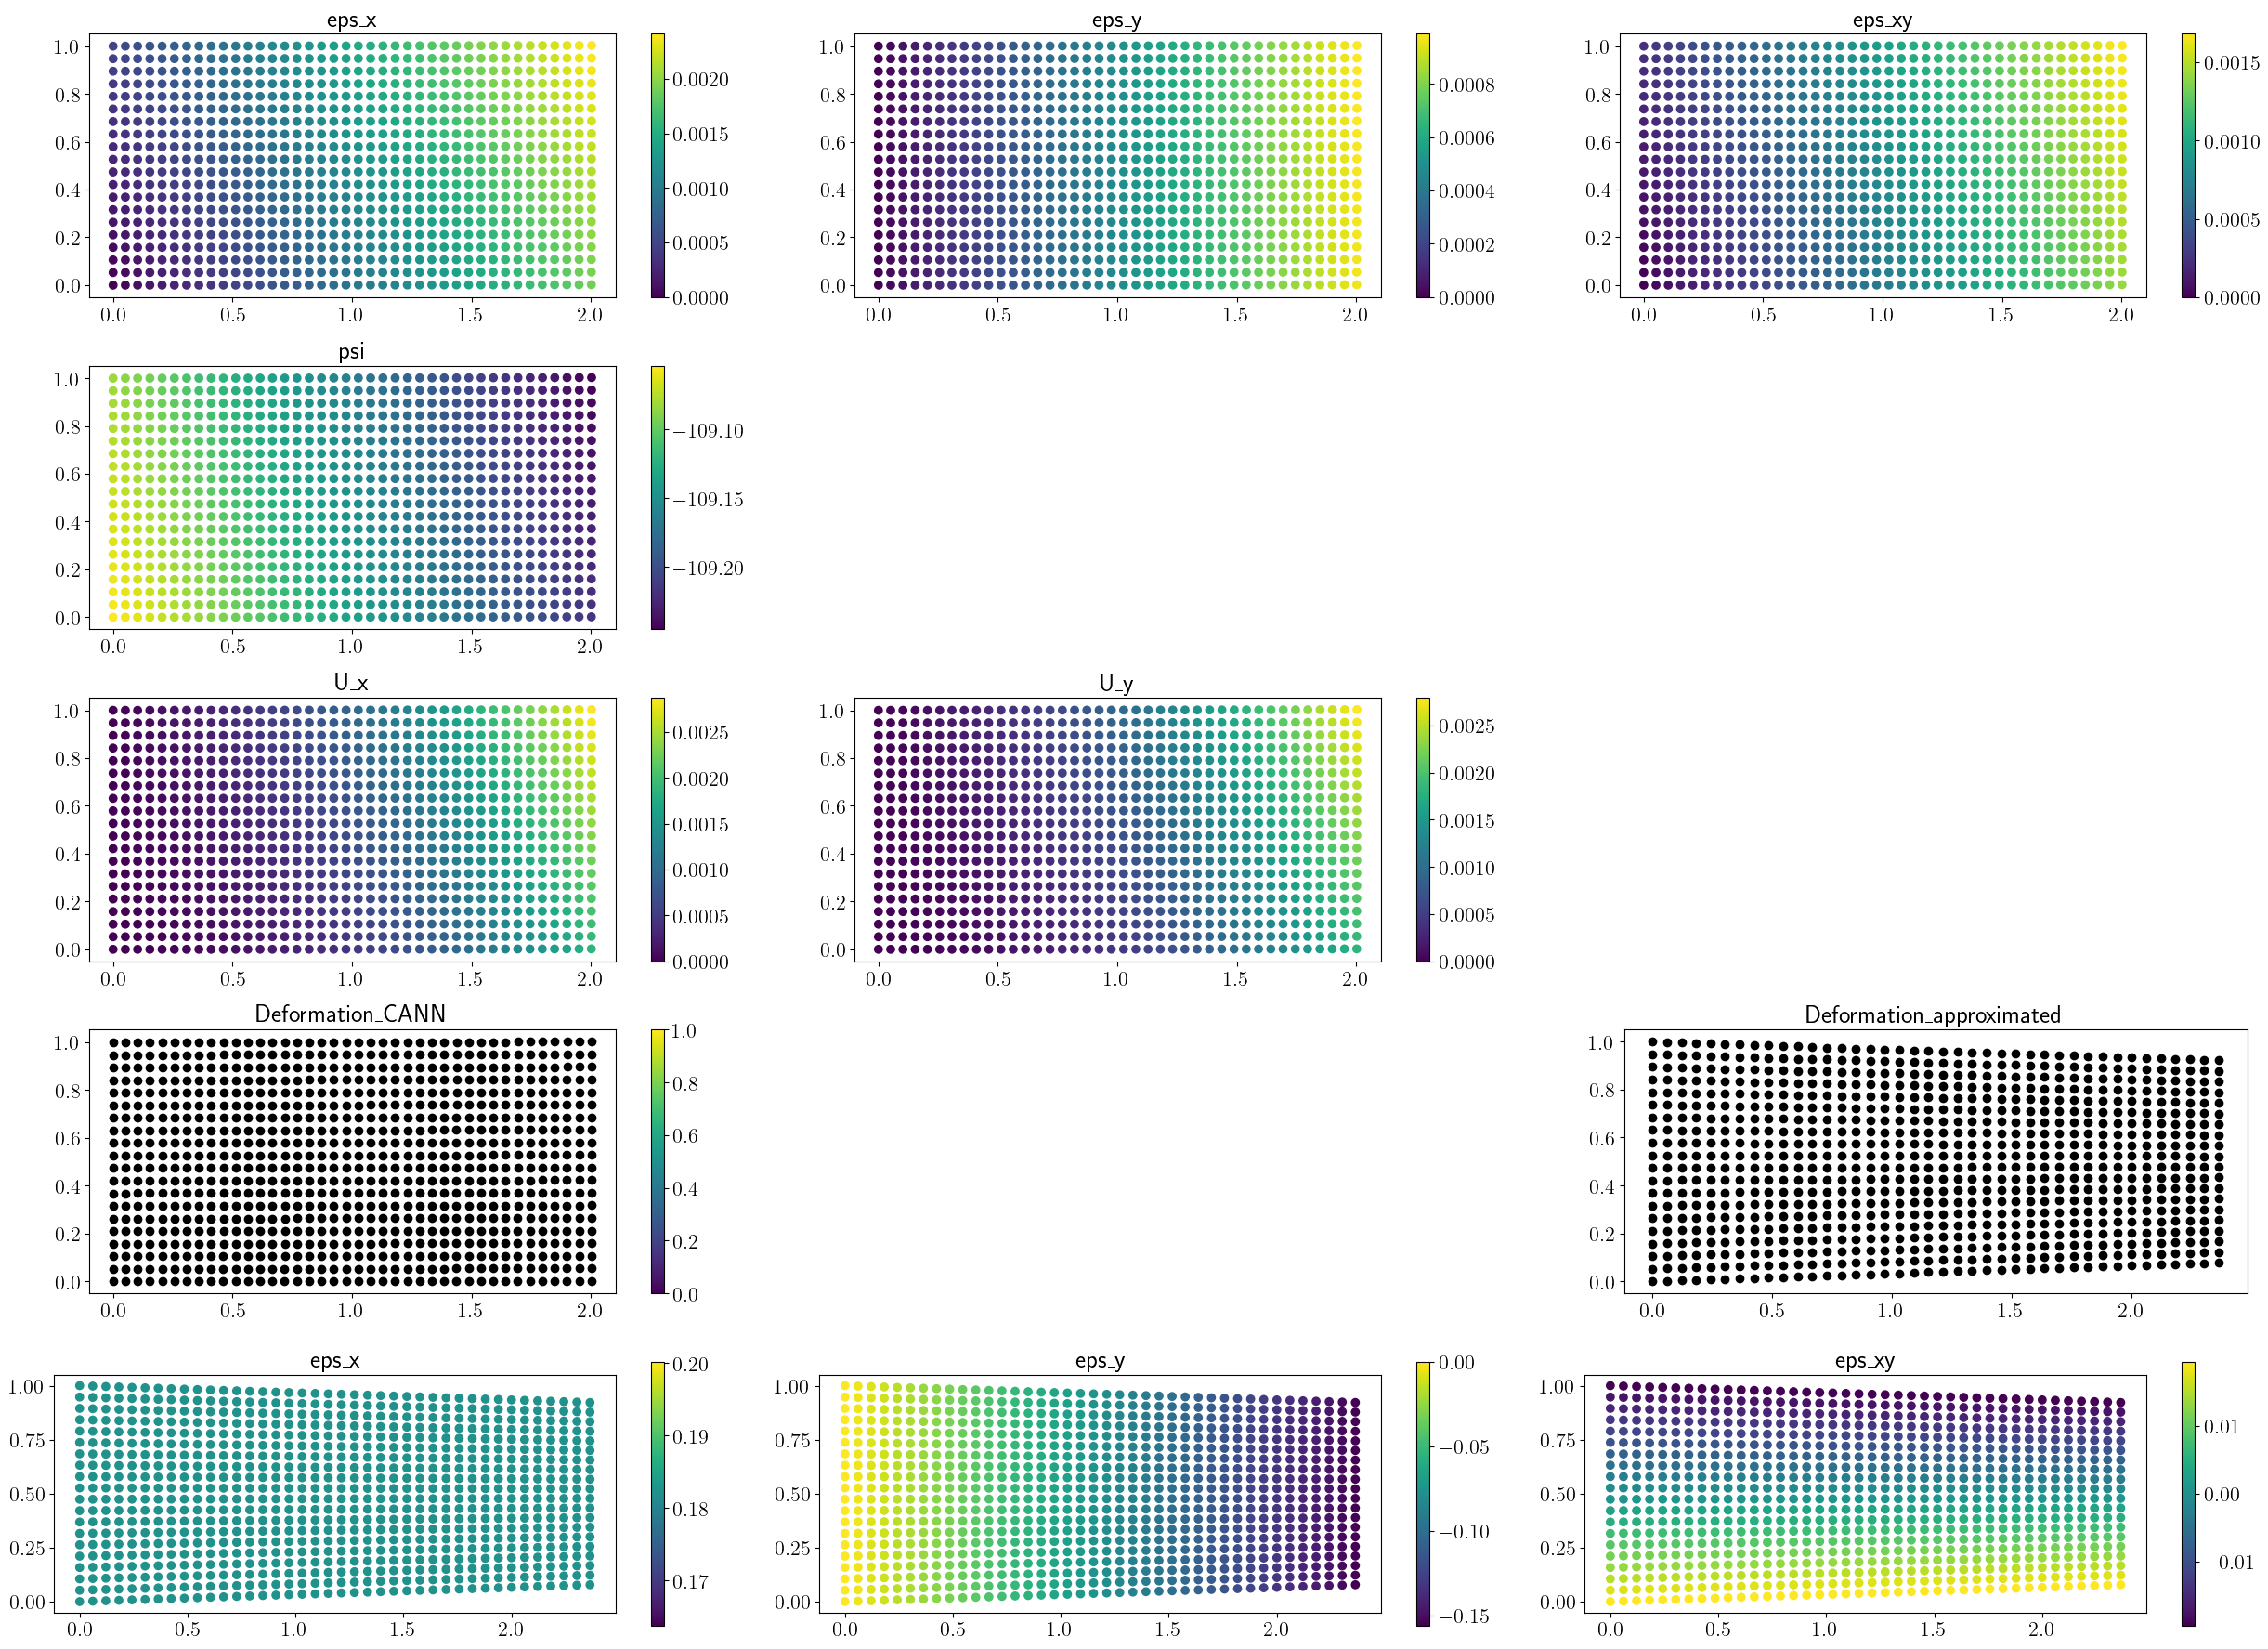

data_driven
loss_left:  tensor(0., grad_fn=<MseLossBackward0>)
loss_right:  tensor(1344.0307, grad_fn=<AddBackward0>)
div_loss:  tensor(8173.6758, grad_fn=<MseLossBackward0>)
Epoch 1/20001, Total Loss: 1.0070435160197826917283236980438232421875000000000000000000000000e+04
loss_left:  tensor(0., grad_fn=<MseLossBackward0>)
loss_right:  tensor(1497.7418, grad_fn=<AddBackward0>)
div_loss:  tensor(1292.2557, grad_fn=<MseLossBackward0>)
Epoch 2/20001, Total Loss: 3.3678814209777210635365918278694152832031250000000000000000000000e+03
loss_left:  tensor(0., grad_fn=<MseLossBackward0>)
loss_right:  tensor(1517.1978, grad_fn=<AddBackward0>)
div_loss:  tensor(206.9365, grad_fn=<MseLossBackward0>)
Epoch 3/20001, Total Loss: 2.3007639679939366033067926764488220214843750000000000000000000000e+03
loss_left:  tensor(0., grad_fn=<MseLossBackward0>)
loss_right:  tensor(1488.5658, grad_fn=<AddBackward0>)
div_loss:  tensor(32.6877, grad_fn=<MseLossBackward0>)
Epoch 4/20001, Total Loss: 2.0878273434820193

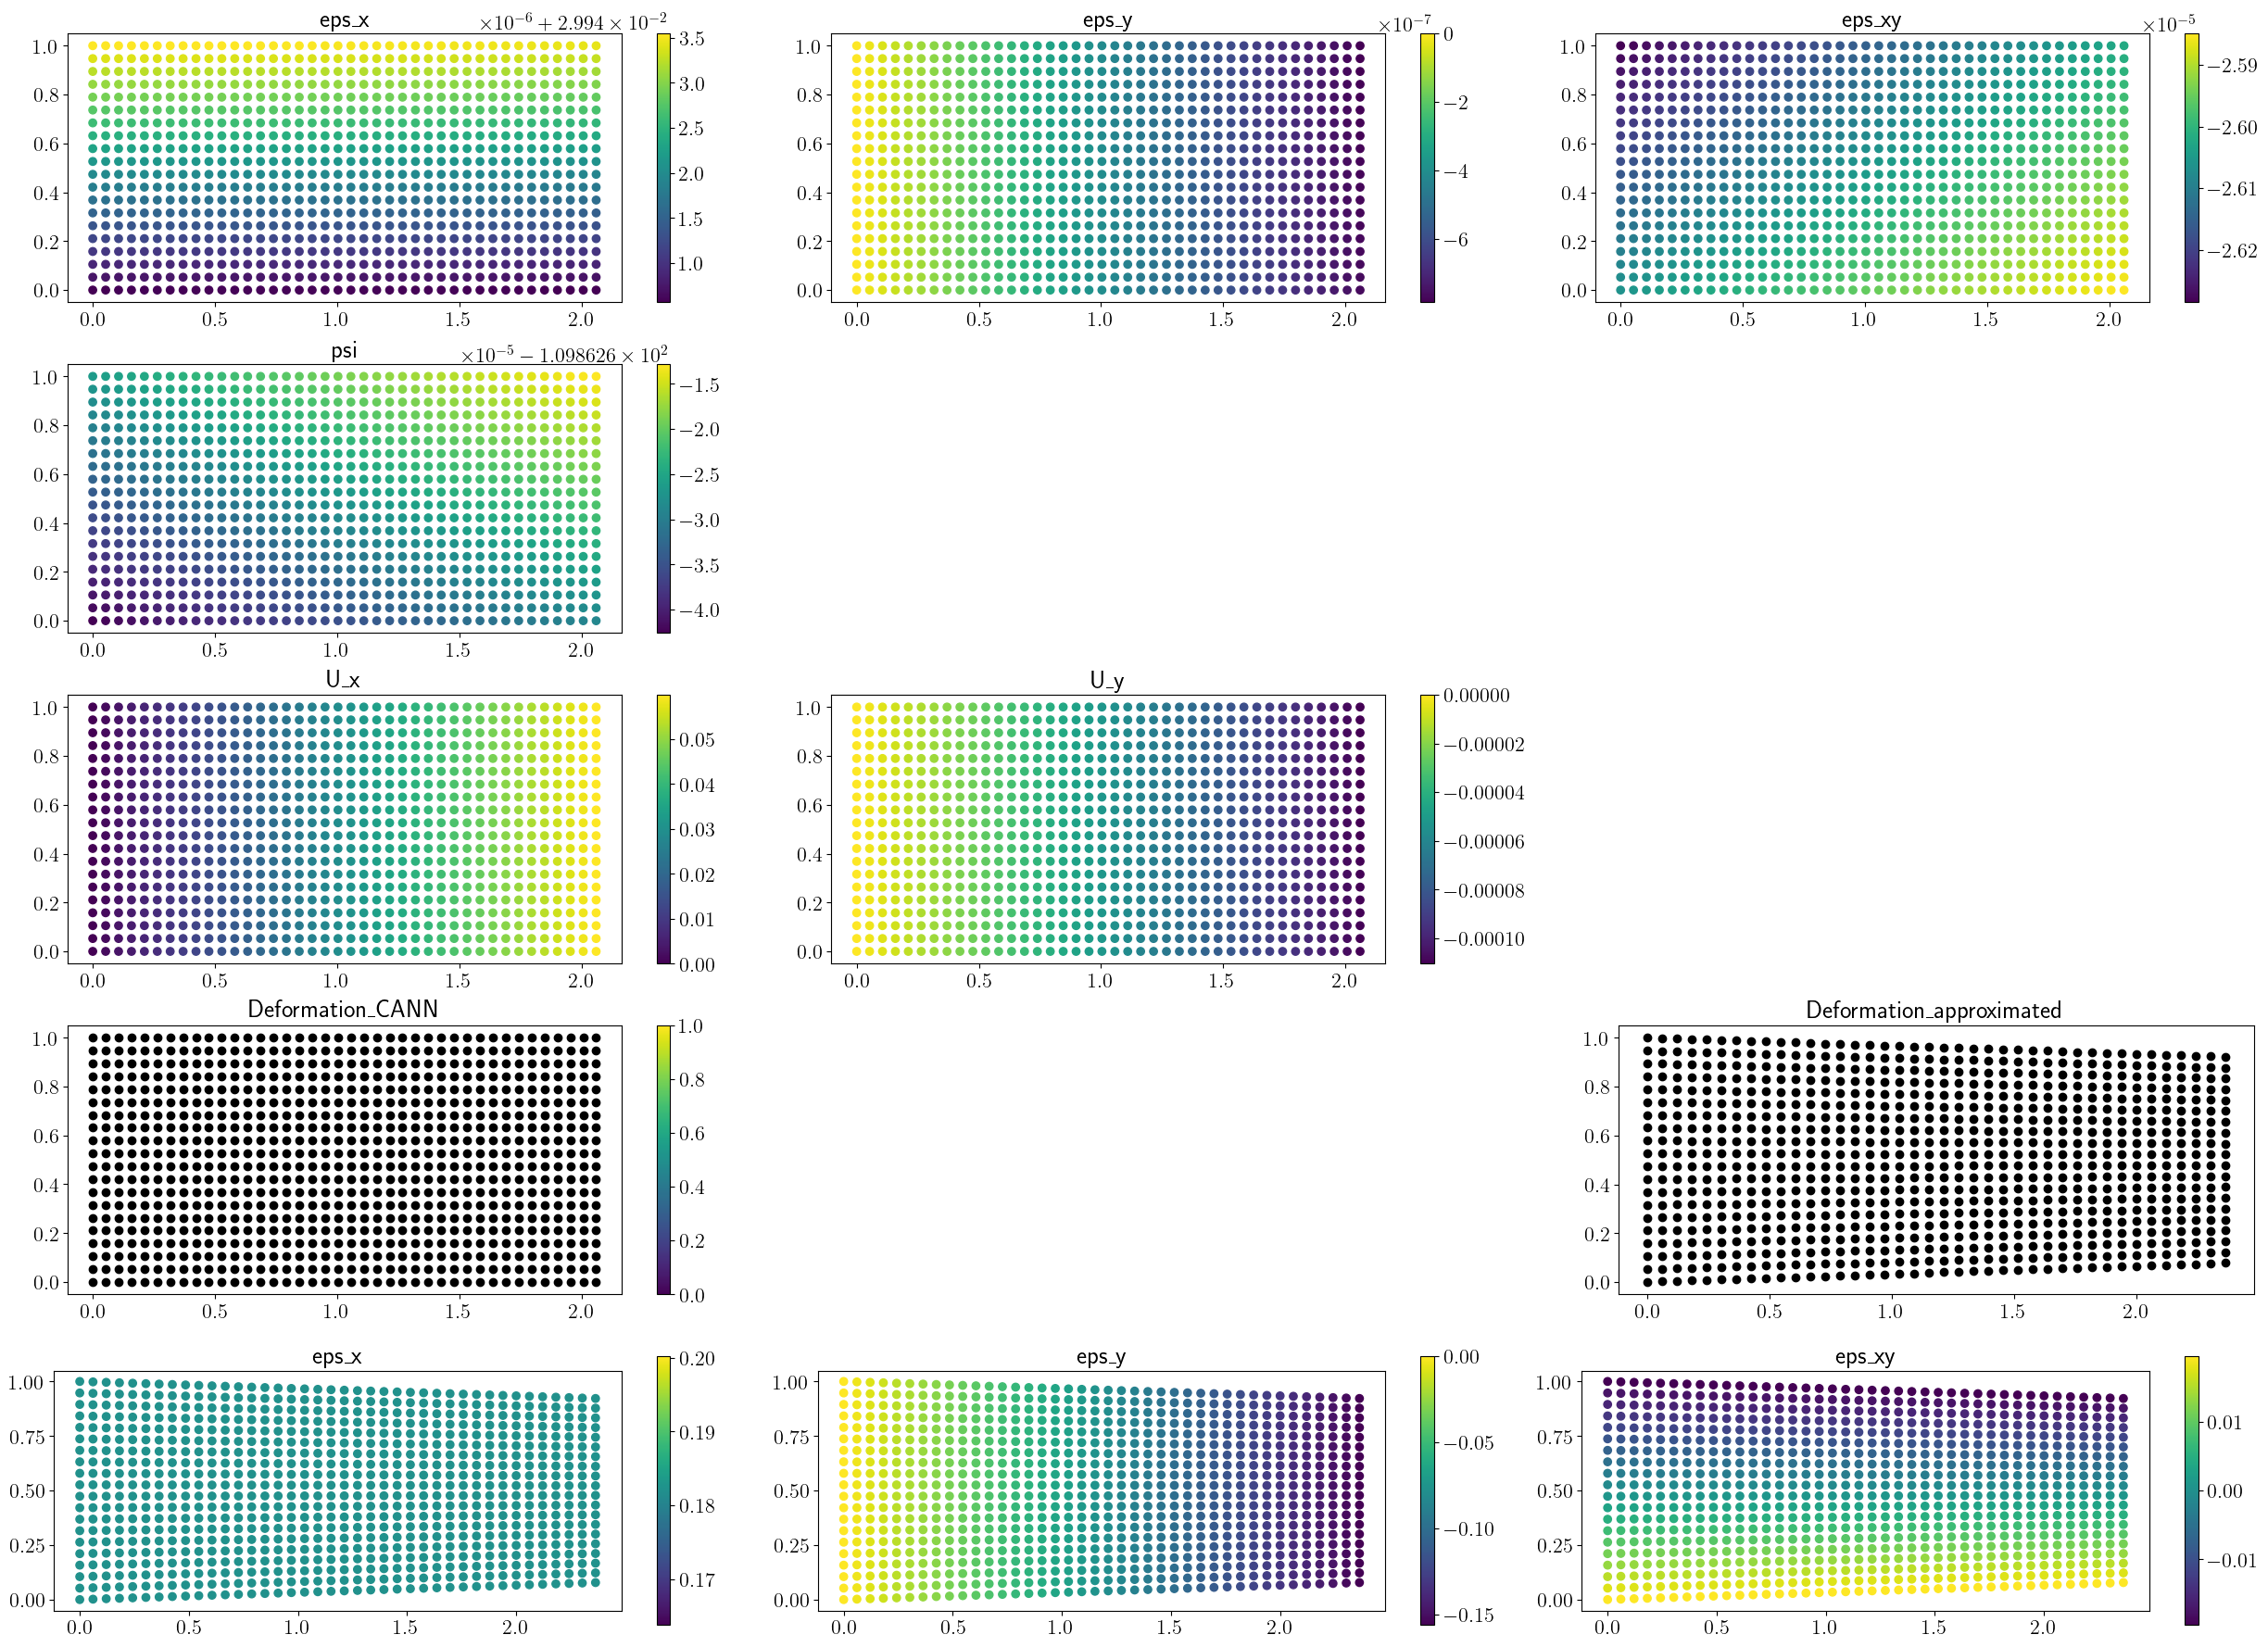

data_driven
loss_left:  tensor(0., grad_fn=<MseLossBackward0>)
loss_right:  tensor(11.3159, grad_fn=<AddBackward0>)
div_loss:  tensor(0.0134, grad_fn=<MseLossBackward0>)
Epoch 1001/20001, Total Loss: -3.4424762658412348947933878662297502160072326660156250000000000000e+00
loss_left:  tensor(0., grad_fn=<MseLossBackward0>)
loss_right:  tensor(11.2850, grad_fn=<AddBackward0>)
div_loss:  tensor(0.0127, grad_fn=<MseLossBackward0>)
Epoch 1002/20001, Total Loss: -3.4437144012898541767242477362742647528648376464843750000000000000e+00
loss_left:  tensor(0., grad_fn=<MseLossBackward0>)
loss_right:  tensor(11.2569, grad_fn=<AddBackward0>)
div_loss:  tensor(0.0119, grad_fn=<MseLossBackward0>)
Epoch 1003/20001, Total Loss: -3.4448666555854337012476662494009360671043395996093750000000000000e+00
loss_left:  tensor(0., grad_fn=<MseLossBackward0>)
loss_right:  tensor(11.2329, grad_fn=<AddBackward0>)
div_loss:  tensor(0.0113, grad_fn=<MseLossBackward0>)
Epoch 1004/20001, Total Loss: -3.44594940160752338

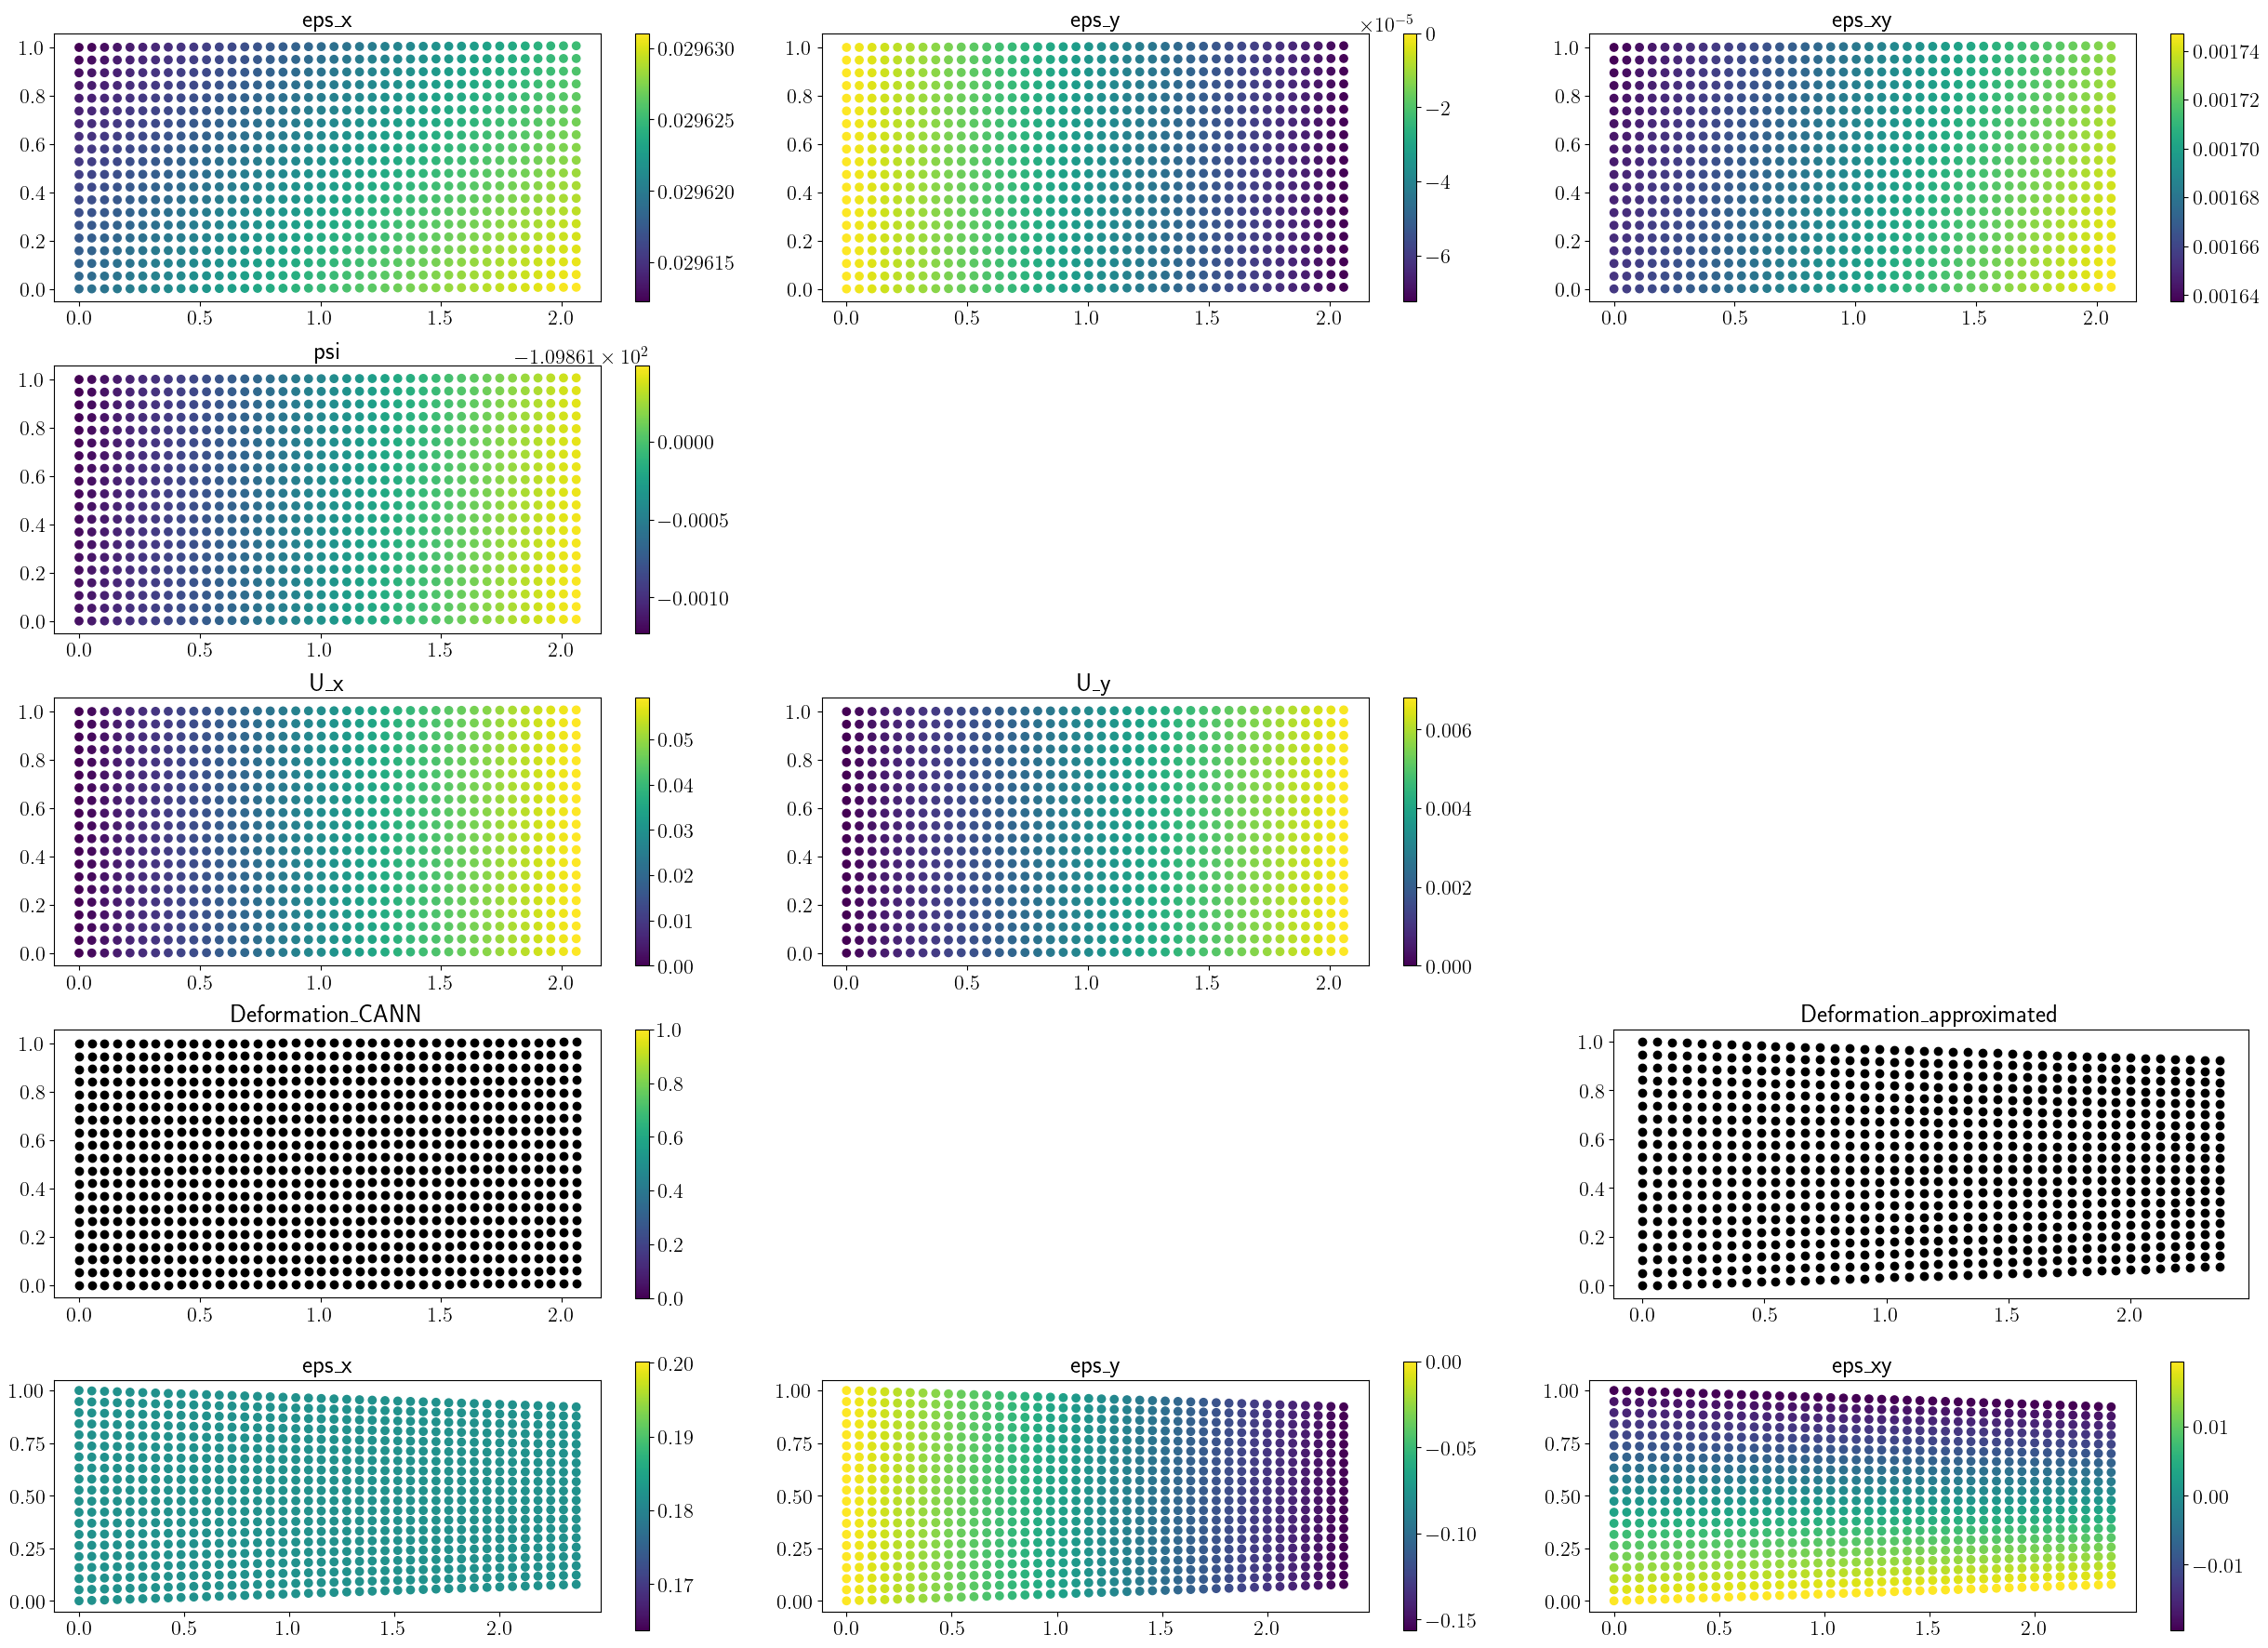

data_driven
loss_left:  tensor(0., grad_fn=<MseLossBackward0>)
loss_right:  tensor(8.3566, grad_fn=<AddBackward0>)
div_loss:  tensor(2.4481, grad_fn=<MseLossBackward0>)
Epoch 2001/20001, Total Loss: -1.6340678762503557663876563310623168945312500000000000000000000000e-01
loss_left:  tensor(0., grad_fn=<MseLossBackward0>)
loss_right:  tensor(8.7354, grad_fn=<AddBackward0>)
div_loss:  tensor(0.5325, grad_fn=<MseLossBackward0>)
Epoch 2002/20001, Total Loss: -2.1876246025194223676635374431498348712921142578125000000000000000e+00
loss_left:  tensor(0., grad_fn=<MseLossBackward0>)
loss_right:  tensor(8.7742, grad_fn=<AddBackward0>)
div_loss:  tensor(5.8208, grad_fn=<MseLossBackward0>)
Epoch 2003/20001, Total Loss: 3.0900843835068236842289479682222008705139160156250000000000000000e+00
loss_left:  tensor(0., grad_fn=<MseLossBackward0>)
loss_right:  tensor(7.1842, grad_fn=<AddBackward0>)
div_loss:  tensor(7.4409, grad_fn=<MseLossBackward0>)
Epoch 2004/20001, Total Loss: 5.01485177192581410565708

KeyboardInterrupt: 

In [16]:
import matplotlib
matplotlib.rcParams["text.usetex"] = True
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

torch.set_default_dtype(torch.float64)
torch.set_num_threads(8) # Use _maximally_ 8 CPU cores
plt.rcParams.update({'font.size': 16})

#device = torch.device("cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
device = torch.device(device)



Lx = 2
Ly = 1
samples_x = 20 * Lx# + 1
samples_y = 20 * Ly# + 1
delta_x = Lx / (samples_x)# - 1)
delta_y = Ly / (samples_y)# - 1)

disp_left = 0
force_right = 0.2
force_upper = 0
force_lower = 0

"""
/|-----------------------| ->
/|                       | ->
/|                       | ->
/|-----------------------| ->
"""

sample_points = torch.meshgrid(torch.linspace(0, Lx, samples_x), torch.linspace(0, Ly, samples_y), indexing='ij')
sample_points = torch.cat((sample_points[0].reshape(-1, 1), sample_points[1].reshape(-1, 1)), dim=1)
sample_points = sample_points.to(device)
sample_points.requires_grad_(True)


hidden_dim = 128
input_dim = 2
output_dim = 2


def plot_undef ():
    plt.subplot(1,1,1)
    plt.scatter(sample_points[:, 0].detach().numpy(), sample_points[:, 1].detach().numpy(), c='black', s=5)

E = 1
nu = 0.3

# convert to plane strain
E = E/(1 - nu**2)
nu = nu / (1 - nu)


mu = E/(2*(1+nu))
lam = E*nu / ((1+nu)*(1-2*nu))

output_dim_cann = 1
# load trained CANN model
## This class creates the actual Neural Network.
class MLNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim_cann):
        super(MLNet, self).__init__()

        # First layer: half linear, half quadratic
        self.layer1_linear = nn.Linear(input_dim, hidden_dim // 2)
        self.layer1_quadratic = nn.Linear(input_dim, hidden_dim // 2)

        # Second layer: half exponential, half linear
        self.layer2_linear = nn.Linear(hidden_dim, hidden_dim // 2)
        self.layer2_exponential = nn.Linear(hidden_dim, hidden_dim // 2)

        # Final layer to combine outputs
        self.output_layer = nn.Linear(hidden_dim, output_dim_cann)

    def forward(self, x):
        # First layer transformations
        linear_out = self.layer1_linear(x)
        quadratic_out = torch.pow(self.layer1_quadratic(x), 2)
        combined1 = torch.cat((linear_out, quadratic_out), dim=1)

        # Second layer transformations
        linear_out2 = self.layer2_linear(combined1)
        exp_out = torch.exp(self.layer2_exponential(combined1))
        combined2 = torch.cat((linear_out2, exp_out), dim=1)

        # Final output layer
        output = self.output_layer(combined2)
        return output

# model = torch.load('CANN_mid4.torch', weights_only=False)
# model = torch.load('CANN.torch', map_location=torch.device('cpu'))

checkpoint = torch.load("CANN_mid4.torch", map_location=torch.device('cpu'))

model = MLNet(input_dim, hidden_dim, output_dim_cann)  
model.load_state_dict(checkpoint['model_state'])
model.eval() ## Set the NN model into evaluation mode

train_x_mean = checkpoint['x_mean']
train_x_std  = checkpoint['x_std']
train_y_mean = checkpoint['y_mean']
train_y_std  = checkpoint['y_std']

def geteps(X, U):
    duxdxy = torch.autograd.grad(U[:, 0].unsqueeze(1), X, torch.ones(X.size()[0], 1, device=device),
                                 create_graph=True, retain_graph=True)[0]
    duydxy = torch.autograd.grad(U[:, 1].unsqueeze(1), X, torch.ones(X.size()[0], 1, device=device),
                                 create_graph=True, retain_graph=True)[0]
    H = torch.zeros(X.size()[0], X.size()[1], X.size()[1], device=device)
    H[:, 0, :] = duxdxy
    H[:, 1, :] = duydxy
    H = H.reshape(samples_x, samples_y, 2, 2)
    eps = H
    eps[:, :, [0, 1], [1, 0]] = 0.5 * (eps[:, :, 0, 1] + eps[:, :, 1, 0]).unsqueeze(2).expand(samples_x, samples_y, 2)
    return eps

def material_model(eps):
    tr_eps = eps.diagonal(offset=0, dim1=-1, dim2=-2).sum(-1)
    sig = 2 * mu * eps + lam * torch.einsum('ij,kl->ijkl', tr_eps, torch.eye(eps.size()[-1], device=device))
    psi = 0.5 * torch.einsum('ijkl,ijkl->ij', eps, sig)
    return psi, sig

def NeoHookean2D(X, U):
    duxdxy = torch.autograd.grad(U[:, 0].unsqueeze(1), X, torch.ones(X.size()[0], 1, device=device), create_graph=True, retain_graph=True)[0]
    duydxy = torch.autograd.grad(U[:, 1].unsqueeze(1), X, torch.ones(X.size()[0], 1, device=device), create_graph=True, retain_graph=True)[0]
    Fxx = duxdxy[:, 0].unsqueeze(1) + 1
    Fxy = duxdxy[:, 1].unsqueeze(1) + 0
    Fyx = duydxy[:, 0].unsqueeze(1) + 0
    Fyy = duydxy[:, 1].unsqueeze(1) + 1
    detF = Fxx * Fyy - Fxy * Fyx
    trC = Fxx ** 2 + Fxy ** 2 + Fyx ** 2 + Fyy ** 2
    #psi = 0.5 * lam * (torch.log(detF) * torch.log(detF)) - mu * torch.log(detF) + 0.5 * mu * (trC - 2)

    # calculate psi using CANN model
    # inputs are trC and detF
    test_x = torch.cat((trC, detF), dim=1)
    # normalize input
    test_x = (test_x - train_x_mean) / train_x_std
    out = model(test_x)
    psi = out * train_y_std + train_y_mean
    # Calculate Piola Kirchoff

    # Compute Piola-Kirchhoff stress components
    Pxx = torch.autograd.grad(psi, Fxx, grad_outputs=torch.ones_like(psi), create_graph=True)[0]  # ∂ψ / ∂Fxx
    Pxy = torch.autograd.grad(psi, Fxy, grad_outputs=torch.ones_like(psi), create_graph=True)[0]  # ∂ψ / ∂Fxy
    Pyx = torch.autograd.grad(psi, Fyx, grad_outputs=torch.ones_like(psi), create_graph=True)[0]  # ∂ψ / ∂Fyx
    Pyy = torch.autograd.grad(psi, Fyy, grad_outputs=torch.ones_like(psi), create_graph=True)[0]  # ∂ψ / ∂Fyy

    # Reshape components to (samples_x, samples_y)
    # Assuming that the number of grid points N = samples_x * samples_y
    Pxx = Pxx.view(samples_x, samples_y)
    Pxy = Pxy.view(samples_x, samples_y)
    Pyx = Pyx.view(samples_x, samples_y)
    Pyy = Pyy.view(samples_x, samples_y)

    # Stack components to form 2x2 matrix for each grid point
    P = torch.stack([
        torch.stack([Pxx, Pxy], dim=-1),  # First row: Pxx, Pxy
        torch.stack([Pyx, Pyy], dim=-1)   # Second row: Pyx, Pyy
    ], dim=-2)  # Stack the rows to create a 2x2 matrix , shape: (samples_x, samples_y, 2, 2)

    # Compute Cauchy stress tensor sigma
    Fxx = Fxx.view(samples_x, samples_y)
    Fxy = Fxy.view(samples_x, samples_y)
    Fyx = Fyx.view(samples_x, samples_y)
    Fyy = Fyy.view(samples_x, samples_y)

    FinvT = torch.inverse(torch.stack([
        torch.stack([Fxx, Fxy], dim=-1),  # First row: Fxx, Fxy
        torch.stack([Fyx, Fyy], dim=-1)   # Second row: Fyx, Fyy
    ], dim=-2)).transpose(-1, -2)  # Transpose for F^-T
    
    sigma = (1 / detF.view(samples_x, samples_y, 1, 1)) * torch.matmul(P, FinvT)
    
    return psi, P, sigma


def integratePsi (psi):
    # PyTorch has a built-in function for trapezoidal integration.
    # Hence, we can use it (nested for the 2 dimensions)
    # The comparison with midpoint rule showed no
    # difference to the midpoint rule significant for the basic stability of this DEM code
    #PSI = torch.trapezoid(torch.trapezoid(psi, dx = delta_y, dim=1), dx = delta_x, dim=0)

    # Apply Simpson's rule along the y-axis (dim=1)
    n_y = psi.shape[1]
    weights_y = torch.ones(n_y).to(device)
    weights_y[1:-1:2] = 4
    weights_y[2:-1:2] = 2
    integral_y = (delta_y / 3) * torch.sum(weights_y * psi, dim=1)

    # Apply Simpson's rule along the x-axis (dim=0) to the result of the y-axis integration
    n_x = psi.shape[0]
    weights_x = torch.ones(n_x).to(device)
    weights_x[1:-1:2] = 4
    weights_x[2:-1:2] = 2
    PSI = (delta_x / 3) * torch.sum(weights_x * integral_y)

    return PSI

def calculateDivergenceLoss(sig):
    criterion = nn.MSELoss(reduction="sum")
    div_sig = (1 / (2 * delta_x) * (sig[2:, 1:-1, :, 0] - sig[:-2, 1:-1, :, 0]))
    div_sig += (1 / (2 * delta_y) * (sig[1:-1, 2:, :, 1] - sig[1:-1, :-2, :, 1]))
    div_loss = criterion(div_sig, torch.zeros(samples_x - 2, samples_y - 2, 2, device=device))
    print("div_loss: ", div_loss)
    return div_loss

def calculateDivergenceLossP(P):
    criterion = nn.MSELoss(reduction="sum")
    div_P = (1 / (2 * delta_x) * (P[2:, 1:-1, 0, 0] - P[:-2, 1:-1, 0, 0]))
    div_P += (1 / (2 * delta_y) * (P[1:-1, 2:, 1, 1] - P[1:-1, :-2, 1, 1]))
    div_loss = criterion(div_P, torch.zeros(samples_x - 2, samples_y - 2, device=device))
    print("div_loss: ", div_loss)
    return div_loss

def calculateDivergenceLossP(P):
    criterion = nn.MSELoss(reduction="sum")

    # Calculate divergence in x-direction (d/dx) for Pxx and Pxy components
    div_P_x = (1 / (2 * delta_x) * (P[2:, 1:-1, 0, 0] - P[:-2, 1:-1, 0, 0]))  # ∂Pxx/∂x
    div_P_x += (1 / (2 * delta_y) * (P[1:-1, 2:, 0, 1] - P[1:-1, :-2, 0, 1]))  # ∂Pxy/∂y

    # Calculate divergence in y-direction (d/dy) for Pyx and Pyy components
    div_P_y = (1 / (2 * delta_x) * (P[2:, 1:-1, 1, 0] - P[:-2, 1:-1, 1, 0]))  # ∂Pyx/∂x
    div_P_y += (1 / (2 * delta_y) * (P[1:-1, 2:, 1, 1] - P[1:-1, :-2, 1, 1]))  # ∂Pyy/∂y

    # Combine the x and y components of the divergence
    div_P = div_P_x + div_P_y

    # Compute the divergence loss with respect to zero (as per the weak form)
    div_loss = criterion(div_P, torch.zeros(samples_x - 2, samples_y - 2, device=device))

    print("div_loss: ", div_loss)
    return div_loss


def integrateTractionEnergy(U, sig):
    # Again, use built-in integration
    # Before, there was a bug: Only the farmost right points have to be integrated
    # Not U[:, :, 0], but U[-1, :, 0]
    # This bug is fixed here:
    #Ty = force_right * torch.trapezoid(U[-1, :, 0], dx = delta_y)

    # Extract the displacement at the right boundary
    U_right = U[-1, :, 0]

    # Number of points (make sure to have an even number of points for Simpson's rule)
    n = U_right.size(0)
    
    if n % 2 == 1:
        raise ValueError("Number of points must be even for Simpson's rule.")

    # Apply Simpson's rule
    weights = torch.ones(n, device=device)
    weights[1:-1:2] = 4  # Multiply every other weight by 4 (odd indices)
    weights[2:-1:2] = 2  # Multiply intermediate weights by 2 (even indices)

    # Calculate the integral using Simpson's rule
    integral = (delta_y / 3) * torch.sum(weights * U_right)
    # Then calculate Ty
    Ty = force_right * integral

    # Theoretically, the traction is calculated from the stress, not the force boundary condition
    # So it's up to comparison what performs better.
    #Ty = torch.trapezoid(sig[-1, :, 0, 0] * U[-1, :, 0], dx=delta_y)

    # The x-component was not necessary, so far
    # Careful: the bug was not fixed here!
    #Tx = (sig[1:-1, :, 0, 0] * U[1:-1, :, 0]).sum()
    #Tx += (sig[:, 1:-1, 1, 1] * U[:, 1:-1, 1]).sum()
    #Tx += 0.5 * (sig[[0, -1], [0, -1], 1, 1] * U[[0, -1], [0, -1], 1]).sum()
    #Tx *= delta_x

    return Ty #+ Tx

def boundaryLosses(U, sig):
    criterion = nn.MSELoss(reduction="sum")
    # New factor to multiply the losses for fixed / Dirichlet B.C.
    # The factor 100*E was too large, i.e. the other conditions were not respected in comparison.
    # The factor 1*E was too small, i.e. the B.C. was not fulfilled well
    loss_left = criterion(delta_y * U[0, :, :] * E*10, torch.zeros(samples_y, 2, device=device))

    # no fundamental changes
    forces_right = torch.ones(samples_y, device=device)
    forces_right[[0, -1]] = 0.5 * torch.ones(2, device=device)
    forces_right *= force_right * delta_y

    # Factor of 10 introduced to improve the compliance with this B.C.
    tractions_right = sig[-1, :, 0, 0] * delta_y
    tractions_right[[0, -1]] *= 0.5
    loss_right = 10*criterion(tractions_right, forces_right)

    # no changes
    sheartractions_right = sig[-1, :, 0, 1] * delta_y
    loss_right += criterion(sheartractions_right, torch.zeros(samples_y, device=device))
    tractions_lower = sig[1:-1, 0, 1, 1] * delta_x
    loss_lower = criterion(tractions_lower, torch.zeros(samples_x - 2, device=device))
    sheartractions_lower = sig[1:-1, 0, 1, 0] * delta_x
    loss_lower += criterion(sheartractions_lower, torch.zeros(samples_x - 2, device=device))
    tractions_upper = sig[1:-1, -1, 1, 1] * delta_x
    loss_upper = criterion(tractions_upper, torch.zeros(samples_x - 2, device=device))
    sheartractions_upper = sig[1:-1, -1, 1, 0] * delta_x
    loss_upper += criterion(sheartractions_upper, torch.zeros(samples_x - 2, device=device))

    print("loss_left: ", loss_left)
    print("loss_right: ", loss_right)

    bc_losses = loss_right + loss_left + loss_upper + loss_lower
    return bc_losses

def losses(U, plot, data_driven):
    eps = geteps(sample_points, U)
    # psi, sig = material_model(eps)
    psi, P, sig = NeoHookean2D(sample_points, U)

    # Cool plots to better understand what's going on
    if plot:
        plt.figure(figsize=(25, 25))
        plt.subplot(7, 3, 1)
        plt.gca().set_aspect('equal')
        plt.scatter((sample_points[:, 0] + U[:, 0]).detach().cpu().numpy(),
                    (sample_points[:, 1] + U[:, 1]).detach().cpu().numpy(),
                    c=(eps[:, :, 0, 0].detach().cpu().numpy()))
        plt.colorbar()
        plt.title("eps_x")
        plt.subplot(7, 3, 2)
        plt.gca().set_aspect('equal')
        plt.scatter((sample_points[:, 0] + U[:, 0]).detach().cpu().numpy(),
                    (sample_points[:, 1] + U[:, 1]).detach().cpu().numpy(),
                    c=(eps[:, :, 1, 1].detach().cpu().numpy()))
        plt.colorbar()
        plt.title("eps_y")
        plt.subplot(7, 3, 3)
        plt.gca().set_aspect('equal')
        plt.scatter((sample_points[:, 0] + U[:, 0]).detach().cpu().numpy(),
                    (sample_points[:, 1] + U[:, 1]).detach().cpu().numpy(),
                    c=(eps[:, :, 0, 1].detach().cpu().numpy()))
        plt.title("eps_xy")
        plt.colorbar()
        plt.subplot(7, 3, 4)
        plt.gca().set_aspect('equal')
        plt.scatter((sample_points[:, 0] + U[:, 0]).detach().cpu().numpy(),
                    (sample_points[:, 1] + U[:, 1]).detach().cpu().numpy(),
                    c=(psi[:, :].detach().cpu().numpy()))
        plt.colorbar()
        plt.title("psi")

        plt.subplot(7, 3, 7)
        plt.gca().set_aspect('equal')
        plt.scatter((sample_points[:, 0] + U[:, 0]).detach().cpu().numpy(),
                    (sample_points[:, 1] + U[:, 1]).detach().cpu().numpy(),
                    c=(U[:, 0].detach().cpu().numpy()))
        plt.title("U_x")
        plt.colorbar()
        plt.subplot(7, 3, 8)
        plt.gca().set_aspect('equal')
        plt.scatter((sample_points[:, 0] + U[:, 0]).detach().cpu().numpy(),
                    (sample_points[:, 1] + U[:, 1]).detach().cpu().numpy(),
                    c=(U[:, 1].detach().cpu().numpy()))
        plt.title("U_y")
        plt.colorbar()

        plt.subplot(7, 3, 10)
        plt.gca().set_aspect('equal')
        plt.scatter((sample_points[:, 0] + U[:, 0]).detach().cpu().numpy(),
                    (sample_points[:, 1] + U[:, 1]).detach().cpu().numpy(),
                    c='black')
        plt.title("Deformation_CANN")
        plt.colorbar()

        plt.tight_layout()


    U = U.reshape(samples_x, samples_y, 2)
    PSI = integratePsi(psi)
    T = integrateTractionEnergy(U, sig)
    bc_losses = boundaryLosses(U, sig)
    # The divergence loss result is not used anymore,
    # but calculated and printed for more insight into the behavior/ what's going on

    div_losses = calculateDivergenceLoss(P)
    # print("T-PSI: ", T - PSI)
    # print("PSI: ", PSI)
    # print("T: ", T)

    # New: calculate an _approximated_ analytical solution
    # (Actually, the lateral shrinkage is not linear!)
    # It can be used for a data-driven training of the NN --> see, if the NN architecture
    # is qualitatively capable of approximating the solution.
    # It also helped to find bugs if the NN was trained data-driven first and then physics-informed, afterwards.
    delta_l = force_right/(E*1/Lx)
    U_target = torch.zeros_like(sample_points)
    U_target[:, 0] = sample_points[:, 0]/Lx * delta_l
    U_target[:, 1] = -sample_points[:, 0]/Lx * nu * (sample_points[:, 1] / Ly - 0.5) * delta_l

    # Plot the _approximated solution_
    if plot:
        plt.subplot(7, 3, 12)
        plt.gca().set_aspect('equal')
        plt.scatter((sample_points[:, 0] + U_target[:, 0]).detach().cpu().numpy(),
                    (sample_points[:, 1] + U_target[:, 1]).detach().cpu().numpy(),
                    c='black')
        plt.title("Deformation_approximated")

        eps = geteps(sample_points, U_target)

        plt.subplot(7, 3, 13)
        plt.gca().set_aspect('equal')
        plt.scatter((sample_points[:, 0] + U_target[:, 0]).detach().cpu().numpy(),
                    (sample_points[:, 1] + U_target[:, 1]).detach().cpu().numpy(),
                    c=(eps[:, :, 0, 0].detach().cpu().numpy()))
        plt.colorbar()
        plt.title("eps_x")

        plt.subplot(7, 3, 14)
        plt.gca().set_aspect('equal')
        plt.scatter((sample_points[:, 0] + U_target[:, 0]).detach().cpu().numpy(),
                    (sample_points[:, 1] + U_target[:, 1]).detach().cpu().numpy(),
                    c=(eps[:, :, 1, 1].detach().cpu().numpy()))
        plt.colorbar()
        plt.title("eps_y")

        plt.subplot(7, 3, 15)
        plt.gca().set_aspect('equal')
        plt.scatter((sample_points[:, 0] + U_target[:, 0]).detach().cpu().numpy(),
                    (sample_points[:, 1] + U_target[:, 1]).detach().cpu().numpy(),
                    c=(eps[:, :, 0, 1].detach().cpu().numpy()))
        plt.colorbar()
        plt.title("eps_xy")

        plt.show()

    # For data-driven training
    U_target = U_target.reshape(samples_x, samples_y, 2)
    criterion = nn.MSELoss(reduction="sum")

    if data_driven:
        print ("data_driven")
        return criterion(U, U_target)
    else:
        #return torch.abs(T - PSI) + 1 * bc_losses  + 0 * div_losses
        return PSI - T + 1 * bc_losses + div_losses

# This allows to choose another (random) initialization for the NN parameters
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.uniform_(m.weight, 0, 0.01)
        #torch.nn.init.normal_(m.weight, mean=0.5/hidden_dim, std=10*1.0/hidden_dim)
        torch.nn.init.zeros_(m.bias)

# This is a custom activation function, that even has an own NN parameter (self.slope)
class myPow(nn.Module):
    def __init__(self):
        super().__init__()
        self.slope = torch.nn.Parameter(torch.ones(1))

    def forward(self, x):
        return torch.pow(x, 2) + self.slope * x

class MLDEMNet(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3):
        super(MLDEMNet, self).__init__()
        self.hidden_dim = hidden_dim

        # Construct the hidden layers dynamically based on num_layers
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim, bias=True))
        #layers.append(nn.Tanh())  # Activation function
        layers.append(myPow())  # Custom activation function

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim, bias=True))
            #layers.append(nn.Tanh())
            layers.append(myPow())

        # Add the final layer
        layers.append(nn.Linear(hidden_dim, output_dim, bias=True))
        
        # Sequential model
        self.fcnn1 = nn.Sequential(*layers)

        # self.fcnn1 = nn.Sequential(
        #     nn.Linear(input_dim, hidden_dim, bias=True),
        #     nn.Tanh(),
        #     #myPow(), #--> so easy is it to use a custom activation function
        #     # Which one is better? Try it out!
        #     nn.Linear(hidden_dim, output_dim, bias=True),
        # )
        self.fcnn1.apply(weights_init) #--> comment in to apply the custom (random) intialization function

    def forward(self, x):
        #x_in = torch.cat((x[:, 0].unsqueeze(1)/Lx, x[:, 1].unsqueeze(1)/Ly - 0.5), dim=1) -> Normalize inputs, try it out!
        x_in = x
        out = force_right/(E*1/Lx) * self.fcnn1(x_in)
        #out = self.fcnn1(x)
        out[:, 0] *= x[:, 0]
        out[:, 1] *= x[:, 0] #--> In the literature a common output transformation, not proven to be necessary, here
        # In fact, that includes problem specific information and obstructs generalizability of the method
        # to a certain extent
        return out

# Should the training start data-driven with the _approximated_ solution as target values?
data_driven = False #True

def train():
    model = MLDEMNet(input_dim, hidden_dim, output_dim)
    model.to(device)
    #optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01, max_iter=20)#, line_search_fn='strong_wolfe')
    # Adam has given much better results than LBFGS during the test runs for this sourcecode version.
    # lr=0.01 is not optimized, but this order of magnitude performed comparatively well.
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-4)
    epochs = 20001
    for epoch in range(epochs):
        model.train()
        #if (epoch + 1) % 3 == 0:
        #    global force_right
        #    if force_right < 0.05:
        #        force_right += 0.03
        if epoch > 1000:
            global data_driven
            data_driven = False # --> the following epochs will be a kind of transfer learning
        if (epoch) % 1000 == 0:
            U = model(sample_points)
            print("force_right: ", force_right)
            losses(U, True, True)
            plt.show()

        def closure():
            U = model(sample_points)
            global data_driven
            loss = losses(U, False, data_driven)
            print('Epoch %i/%i, Total Loss: %.64e' % (epoch+1, epochs, loss.item()))
            optimizer.zero_grad()
            loss.backward()
            return loss
        loss = closure()
        optimizer.step()
        #optimizer.step(closure)
    return

train()

Epoch=0, Loss=99.026314, Internal=0.018711, Work=0.020546, BC_left=9.902815e-03
Epoch=200, Loss=-0.020581, Internal=0.029145, Work=0.062548, BC_left=1.282162e-06
Epoch=400, Loss=-0.034480, Internal=0.036139, Work=0.073960, BC_left=3.341108e-07
Epoch=600, Loss=-0.038306, Internal=0.040137, Work=0.079287, BC_left=8.441945e-08
Epoch=800, Loss=-0.039250, Internal=0.042121, Work=0.081700, BC_left=3.287364e-08
Epoch=1000, Loss=-0.039597, Internal=0.042870, Work=0.082655, BC_left=1.879280e-08
Epoch=1200, Loss=-0.009620, Internal=0.042887, Work=0.082363, BC_left=2.985577e-06
Epoch=1400, Loss=-0.039924, Internal=0.043308, Work=0.083355, BC_left=1.229705e-08
Epoch=1600, Loss=-0.040026, Internal=0.043431, Work=0.083572, BC_left=1.152567e-08
Epoch=1800, Loss=-0.007400, Internal=0.043639, Work=0.083429, BC_left=3.238904e-06
Epoch=2000, Loss=-0.040175, Internal=0.043727, Work=0.084005, BC_left=1.032957e-08
Epoch=2200, Loss=-0.040227, Internal=0.043820, Work=0.084150, BC_left=1.031883e-08
Epoch=2400,

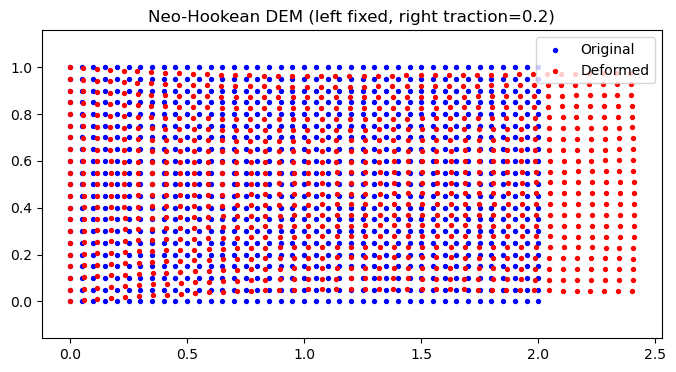

In [ ]:
#---------------------------the Neo-Hookean model with DEM--------------------------------
import torch
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------
# 1. 材料及域参数
# -------------------
Lx, Ly = 2.0, 1.0  # 尺寸
E = 1.0
nu = 0.3
mu = E / (2.0 * (1.0 + nu))
lam = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))  # Lame 常数
force_right = 0.2  # 右端施加的牵引力(力控)

# 网格划分
nx, ny = 41, 21  
x = torch.linspace(0, Lx, nx)
y = torch.linspace(0, Ly, ny)
Xv, Yv = torch.meshgrid(x, y, indexing='ij')
points = torch.cat([Xv.reshape(-1,1), Yv.reshape(-1,1)], dim=1).to(device)
points.requires_grad_(True)

dx, dy = Lx/(nx-1), Ly/(ny-1)

# -------------------
# 2. 神经网络
# -------------------
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)

model = NeuralNetwork(2, 64, 2).to(device)

# -------------------
# 3. Neo-Hookean 计算
# -------------------
def compute_deformation_gradient(points, disp):
    """
    disp: (N,2)
    返回 F: (N, 2, 2)
    """
    # 这里用 autograd 计算 ∂u/∂x, ∂u/∂y
    # 注意要对每个分量分别求 grad，所以写两次 grad
    u_sum_x = disp[:,0].sum()  # sum()只是为了简化 grad 计算
    u_sum_y = disp[:,1].sum()

    grads_x = torch.autograd.grad(u_sum_x, points, create_graph=True)[0]  # (N,2)
    grads_y = torch.autograd.grad(u_sum_y, points, create_graph=True)[0]  # (N,2)

    F = torch.zeros(points.shape[0], 2, 2, device=device)
    # Fxx = 1 + du_x/dx, Fxy = du_x/dy
    F[:,0,0] = 1.0 + grads_x[:,0]
    F[:,0,1] = grads_x[:,1]
    # Fyx = du_y/dx, Fyy = 1 + du_y/dy
    F[:,1,0] = grads_y[:,0]
    F[:,1,1] = 1.0 + grads_y[:,1]

    return F

def neo_hookean_energy_density(F):
    # 2D Neo-Hookean (plane strain)
    C = F.transpose(-1,-2) @ F
    J = torch.det(F)
    I1 = torch.diagonal(C, dim1=-2, dim2=-1).sum(-1)  # trace(C)
    # 常见的一种 NH 表达式:
    # ψ = 0.5 * mu * (I1 - 2 - 2 ln J) + 0.5 * lam * (ln J)^2
    # 也可根据你之前的形式再做调整
    logJ = torch.log(J)
    psi = 0.5*mu*(I1 - 2.0 - 2.0*logJ) + 0.5*lam*(logJ**2)
    return psi

# -------------------
# 4. 训练循环
# -------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

# 为了简化，对右边界做“线性”离散: 只要 right_mask = (x=Lx)
# 在 y 方向把 traction 积分成 sum(...)*dy
left_mask  = (points[:,0] == 0)
right_mask = (points[:,0] == Lx)

num_epochs = 3000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # (a) 预测位移
    disp = model(points)  # (N,2)

    # (b) 内部应变能
    F = compute_deformation_gradient(points, disp)
    psi_elem = neo_hookean_energy_density(F)  # (N,)
    # 用简单 Riemann sum 积分
    internal_energy = psi_elem.sum() * dx * dy

    # (c) 外力做功(右边界)
    # 这里力是 t = 0.2 (x方向), 做功 = ∫ t * u_x dS
    # dS ~ dy （对 x=Lx 边而言）
    disp_right_x = disp[right_mask, 0]  # 右边界节点的 x方向位移
    external_work = (disp_right_x * force_right).sum() * dy

    # (d) 左边界位移固定(Dirichlet)
    #    直接强加: U(0,y) = 0
    #    用 MSELoss 做惩罚
    disp_left = disp[left_mask]  # Nx2
    bc_loss_left = mse(disp_left, torch.zeros_like(disp_left))

    # (e) 总势能 Pi = internal - external
    #    最小化势能 => loss = internal_energy - external_work
    #    但为了更好地收敛，我们也把左边界的位移零条件当作惩罚加进去
    total_loss = internal_energy - external_work + 1e4 * bc_loss_left  
    # 注意：一般对 Dirichlet BC 可以用强制网络输出 x*(some NN) 等方式来“硬满足”；
    # 这里演示用一个较大权重 1e4 的 MSE 来逼迫其变为 0。
    # 你也可以尝试 1e5 或者别的值，看是否收敛更好。

    total_loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch={epoch}, Loss={total_loss.item():.6f}, "
              f"Internal={internal_energy.item():.6f}, Work={external_work.item():.6f}, BC_left={bc_loss_left.item():.6e}")

# -------------------
# 5. 查看结果
# -------------------
with torch.no_grad():
    disp_final = model(points)
    x_def = points[:,0] + disp_final[:,0]
    y_def = points[:,1] + disp_final[:,1]

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.scatter(points[:, 0].detach().cpu(), points[:, 1].detach().cpu(), color='blue', s=8, label='Original')
plt.scatter(x_def.detach().cpu(), y_def.detach().cpu(), color='red', s=8, label='Deformed')
plt.axis('equal')
plt.legend()
plt.title("Neo-Hookean DEM (left fixed, right traction=0.2)")
plt.show()
